In [34]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [35]:
import os
dir = '/Users/signapoop/Desktop/autotune'
os.chdir(dir)
from autotune.core.HyperbandOptimiser import HyperbandOptimiser
from autotune.core.RandomOptimiser import RandomOptimiser
from autotune.core.TpeOptimiser import TpeOptimiser

In [42]:
hyperband = []
random = []
tpe = []
n = 5

for i in range(1,n+1):

    problem_text = "cifar_9hps_" + str(i)
    path = '/Users/signapoop/Desktop/results/' + problem_text
    os.chdir(path)
    file = open("results_new.pkl",'rb')
    object_file = pickle.load(file)
    file.close()
    
    file = open("tpe_only_results.pkl",'rb')
    object_file_2 = pickle.load(file)
    file.close()

    # Unpack file
    hyperband.append(object_file[0])
    random.append(object_file[1])
    tpe.append(object_file_2[0])

In [43]:
def predecessor_t(seq, t):
    assert seq[0] == 0, "First checkpoint must be 0"
    for i in range(len(seq)):
        if seq[i] > t:
            return i -1
    return i 

def value_at_time(opt, t):
    time_index = predecessor_t(opt.checkpoints, t)
    return opt.Y_best[time_index]

def augment_sequences(opt):
    opt.checkpoints.insert(0,0)
    opt.Y_best.insert(0,1)

In [44]:
# augments sequences, prepending checkpoint t=0, Y_best=1
for opt in hyperband: 
    augment_sequences(opt)

for opt in random: 
    augment_sequences(opt)
    
for opt in tpe: 
    augment_sequences(opt)

In [58]:
for h in hyperband:
    print(len(h.checkpoints))
    print(h.Y_best[-1])

13
0.1496
13
0.1648
13
0.1828
13
0.1545
13
0.1512


In [57]:
for r in random:
    print(len(r.checkpoints))
    print(r.Y_best[-1])

26
0.1947
26
0.1694
22
0.1959
27
0.1924
29
0.1887


In [56]:
for r in tpe:
    print(len(r.checkpoints))
    print(r.Y_best[-1])

26
0.1649
26
0.1676
26
0.1722
26
0.2198
26
0.1764


In [48]:
seq = random[0].checkpoints
print(seq)
print(predecessor_t(seq, 4900))
print(value_at_time(random[0], 4900))

[0, 194.32330799102783, 528.8555710315704, 750.0965390205383, 1025.7612609863281, 1351.5884671211243, 1545.2633731365204, 1879.2532091140747, 2179.993893146515, 2426.513422012329, 2653.749006986618, 2978.5604310035706, 3228.538905143738, 3436.684720993042, 3917.765741109848, 4143.167211055756, 4354.643072128296, 4649.495290994644, 5030.1921808719635, 5224.89528799057, 5503.058192014694, 5707.438976049423, 5886.6580119133, 6114.279210090637, 6388.8591730594635, 6585.805742025375]
17
0.2168


In [49]:
def average_opt_results(optimisers):
    t_end = max([opt.checkpoints[-1] for opt in optimisers])
    print(t_end)
    t_seq = np.linspace(0, t_end, num=250)
    
    y_seq = np.zeros((len(optimisers),len(t_seq)))
    for i in range(len(optimisers)):
        for j in range(len(t_seq)):
            y_seq[i][j] = value_at_time(optimisers[i], t_seq[j])
    return t_seq, y_seq

In [50]:
random_t_seq, random_y_seq = average_opt_results(random)
print(random_y_seq.shape)
hyperband_t_seq, hyperband_y_seq = average_opt_results(hyperband)
print(hyperband_y_seq.shape)
tpe_t_seq, tpe_y_seq = average_opt_results(tpe)
print(tpe_y_seq.shape)

7207.74989319
(5, 250)
4692.85442019
(5, 250)
7743.94
(5, 250)


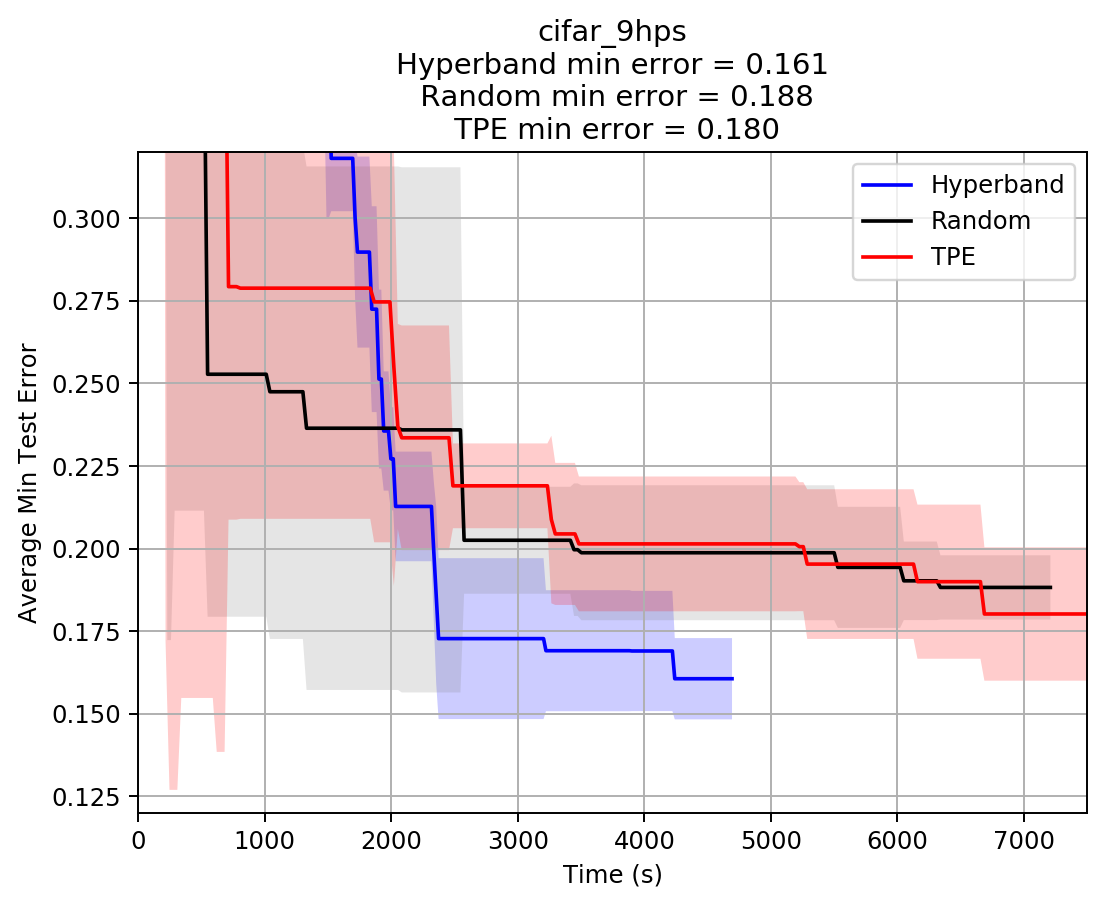

In [54]:
r_a = np.average(random_y_seq, 0)
h_a = np.average(hyperband_y_seq, 0)
t_a = np.average(tpe_y_seq, 0)

r_s = np.std(random_y_seq, 0)
h_s = np.std(hyperband_y_seq, 0)
t_s = np.std(tpe_y_seq, 0)

fig, ax = plt.subplots(1, 1, figsize=(7, 5), dpi=175)
ax.plot(hyperband_t_seq, h_a, '-b', label="Hyperband")
ax.fill_between(hyperband_t_seq, h_a-h_s, h_a+h_s, facecolor='blue', alpha=0.2)

ax.plot(random_t_seq, r_a, '-k', label="Random")
ax.fill_between(random_t_seq, r_a-r_s, r_a+r_s, facecolor='grey', alpha=0.2)

ax.plot(tpe_t_seq, t_a, '-r', label="TPE")
ax.fill_between(tpe_t_seq, t_a-t_s, t_a+t_s, facecolor='red', alpha=0.2)

ax.set_xlim(0.0,7500)
#ax.set_ylim(0.1,0.8)
ax.set_ylim(0.12,0.32)

ax.grid()
plt.ylabel('Average Min Test Error')
plt.xlabel('Time (s)')
plt.legend()

problem_text = "cifar_9hps"

res = "Hyperband min error = {:.3f}\n Random min error = {:.3f}\n TPE min error = {:.3f}".format(min(h_a), min(r_a), min(t_a))
title = problem_text + "\n" + res
plt.title(title)
    
plt.show()

In [17]:
random_std = np.std(random_y_seq, 0)